## MNIST

#### 导包

In [1]:
import sklearn
import numpy as np
import os
np.random.seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#### 下载MNIST： 

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)


In [3]:
mnist['data'].shape

(70000, 784)

Saving figure first digit


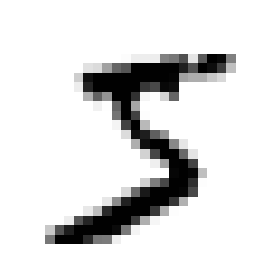

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)

some_digit = X[0]     #拿出第一张图片
some_digit_image = some_digit.reshape(28, 28)  #reshape到二维
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

save_fig("first digit")
plt.show()

Saving figure many_digits_plot


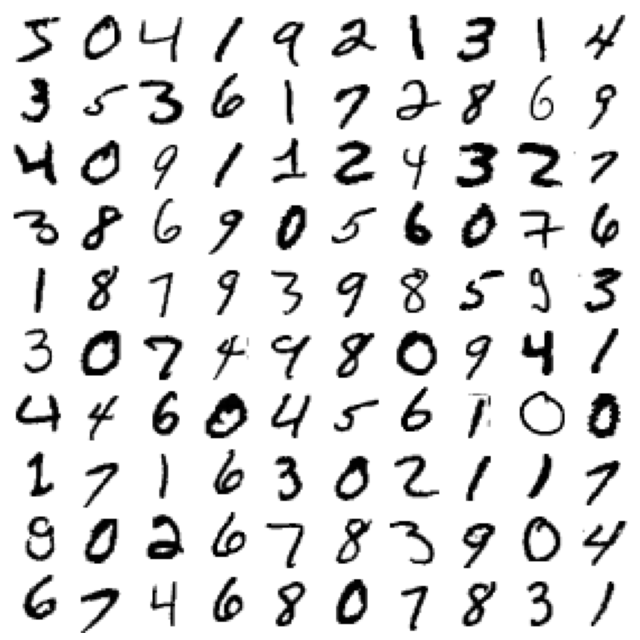

In [5]:
# 编写输出大图的函数
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # 这相当于： n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 我们可以附加空图像以填充网格的末尾：
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 重建数组，使其组织为包含 28×28 图像的网格：
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 合并轴 0,2（垂直图像网格轴和垂直图像轴）,1,3(水平轴)
    # 首先需要使用 transpose() 移动想要组合的轴，然后再重塑：
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 大图已经拼好了，输出：
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
    
plt.figure(figsize=(9,9))  # 创建一个9×9的画布
example_images = X[:100]   # 选取前100张
plot_digits(example_images, images_per_row=10)
save_fig("many_digits_plot")
plt.show()


按照6:1的比例划分训练集测试集

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#### 二元分类器，5和非5

先创建目标向量

In [7]:
# 若为5则为true，非5则为false
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

采用随机梯度下降算法进行分类

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

用3折交叉验证进行评估：

In [9]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

##### 准确率很高，但不代表模型有效，因为数据集偏度太大。

计算混淆矩阵：

In [10]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

#### 精度和召回率

In [11]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [12]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [13]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### 精度召回率权衡

some_digit（也就是第一张图片，“5”）的决策分数

In [14]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

阈值设为0时：

In [15]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

阈值设为8000时：

In [16]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

获取训练集中实例的分数，此次返回决策分数而不是预测结果

In [17]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [18]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


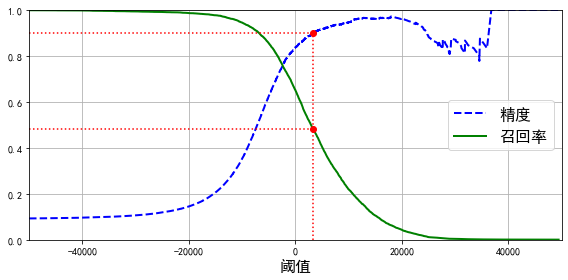

In [19]:
plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
plt.rcParams['axes.unicode_minus']=False   #这两行需要手动设置

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="精度", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="召回率", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("阈值", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

另一种搜索精度/召回率的方法：直接绘制精度和召回率的函数图

Saving figure precision_vs_recall_plot


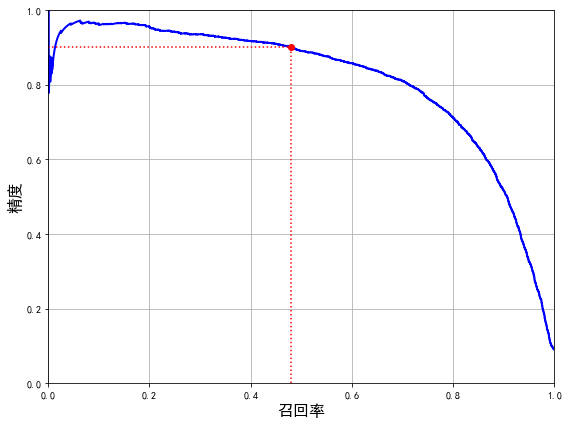

In [20]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("召回率", fontsize=16)
    plt.ylabel("精度", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

假设需要90%的精度，查找图一：

In [21]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

要进行预测，除了调用predict方法，还可以运行如下代码：

In [22]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print('精度:',precision_score(y_train_5, y_train_pred_90)) # 精度
print('召回率:',recall_score(y_train_5, y_train_pred_90)) # 精度

精度: 0.9000345901072293
召回率: 0.4799852425751706


#### 绘制ROC曲线 

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


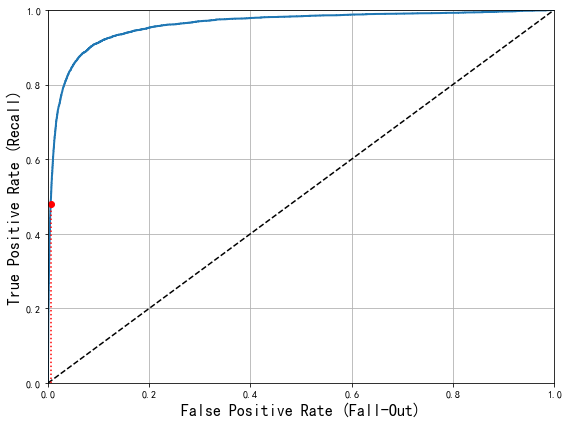

In [24]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # 用于绘制虚线对角线
    plt.axis([0, 1, 0, 1])
    plt.xlabel('假正率', fontsize=16)
    plt.ylabel('真正率（召回率）', fontsize=16)
    plt.grid(True)  

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)] 
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro") 
save_fig("roc_curve_plot")
plt.show()

In [25]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

####  训练随机森林分类器，比较两种分类器的ROC AUC：

In [26]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

由于`roc_curve()`需要标签和分数，但`dict-proba()`函数不提供分数，而是提供类的概率，所以我们直接使用正类的概率作为分数值：

In [27]:
y_scores_forest = y_probas_forest[:, 1] # score = 正类概率
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

对比两个分类器的ROC曲线：

Saving figure roc_curve_comparison_plot


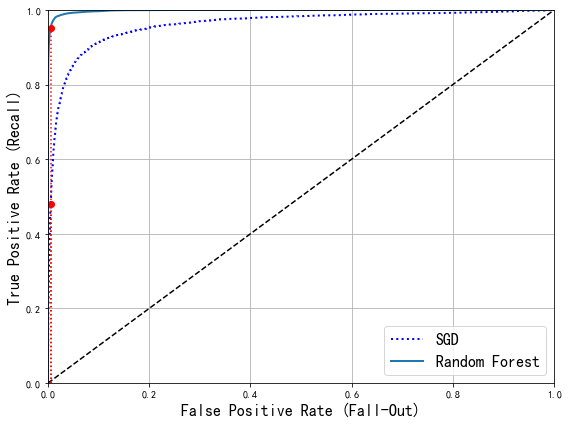

In [28]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "随机森林")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

输出随机森林的曲线：

In [29]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

再测试一下精度和召回率：

In [30]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print('精度:',precision_score(y_train_5, y_train_pred_forest))
print('召回率:',recall_score(y_train_5, y_train_pred_forest))

精度: 0.9905083315756169
召回率: 0.8662608374838591


### 

### 多分类器

用SVM绘制多分类器

先以前1000个作为训练集，预测一下第一张图片（也就是那个老5）：

In [31]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

使用OvR策略，基于SVC创建多分类器：

In [32]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

用SGD分类器直接进行训练：

In [33]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

调用`decision_function()`查看一下分类器将每个实例分类为每个类的概率列表：

In [34]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

用折交叉验证测试一下：

In [35]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [39]:
type(X_train_scaled)

numpy.ndarray